# **Finetuning the phi-1.5 Language Model** 📝

### **Introduction**

Fine-tuning a model, especially one as complex as phi-1.5, is an intricate endeavor demanding a judicious blend of techniques, optimizations, and a profound grasp of the model's architecture. As illustrated in this notebook, each phase—from environment setup to the utilization of the fine-tuned model—is a delicate dance of precision and understanding.

This journey was driven by the [Kaggle Science Exam competition](https://www.kaggle.com/competitions/kaggle-llm-science-exam), where the challenge was to enable a language model to answer multiple-choice questions. These questions were intriguingly generated by GPT 3.5 from a mix of STEM and History Wikipedia articles, offering a deep dive into the realms of synthetic data and knowledge distillation.

My model of choice was [phi-1.5](https://huggingface.co/microsoft/phi-1_5). With only 1.3 billion parameters, it stands as a compact yet potent transformer. Its allure was further amplified by its unique training methodology using synthetic "textbooks", which embodies the essence of a perfect "textbook" as described in the [Textbooks all you need](https://arxiv.org/pdf/2306.11644.pdf) research.

My strategy was multifaceted: 

1. Substitute synthetic textbooks or Wikipedia articles with informative articles from Khan Academy.
2. Harness the GPT 3.5 API to mold MCQs from a sample of 100 Khan Academy "textbooks."
3. Fine-tune phi 1_5 using this dataset to craft MCQs from the remaining textbooks.
4. Employ another LLM to respond to MCQs using [the open-book method](https://www.kaggle.com/code/cdeotte/how-to-train-open-book-model-part-1).

However, challenges arose, particularly at step 3. The limitations, I conjecture, were twofold: the constrained capacity of the Phi 1_ model and the limited training dataset. A larger model, like [Mistral 7B](https://huggingface.co/docs/transformers/main/en/model_doc/mistral), might have been a more potent alternative.

With the aid of libraries like transformers and methodologies such as LoRA, the phi-1.5 model's fine-tuning capabilities offer a promising path for NLP tasks, be it in research or real-world applications. This endeavor, though challenging, was enriched by insights from contributors like [Vasanthengineer](https://github.com/Vasanthengineer4949/NLP-Projects-NHV), whose [video tutorial](https://m.youtube.com/watch?v=R8CKx5yNEDo) proved invaluable.

Now, let's delve into the process of finetuning Phi 1_5 for generating MCQs based on a textbook context.

---


### **Installing Dependencies**

To begin, we need to install a few Python packages which are crucial for our finetuning process:

```python
! pip install accelerate transformers einops datasets peft bitsandbytes
```

---

Once the required packages are installed, the next step is to import them:

```python
from huggingface_hub import notebook_login
notebook_login()

import torch
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import os
```

Here, we are using the Hugging Face's `transformers` library for language model finetuning and `datasets` for data handling.

---

### **Setting Up the Tokenizer**

Before we can start training, we need to set up the tokenizer:

```python
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
```

The tokenizer will be responsible for converting our text data into tokens that the model can understand.

---

### **Configuring the Model**

The phi-1.5 model leverages the `BitsAndBytesConfig` for efficient quantization:

```python
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-1_5",
    device_map={"":0},
    trust_remote_code=True,
    quantization_config=bnb_config
)
```

This configuration ensures the model uses less memory during training, making it more efficient. Lets dicuss the above code in a little more detail.

Alright! Let's delve deeper into the more technical aspects.

---

### **Device Map**

The Phi 1_5 model does not currently support `device_map="auto"`. If you're using just one GPU for a model, you don't necessarily need a device map since the entire model will reside on that single GPU. However, if you still want to set up a device map for one GPU, you can specify all the layers to reside on GPU 0 ` device_map={"":0`.

### **BitsAndBytes**

The `bitsandbytes` library provides a lightweight wrapper around CUDA custom functions, especially 8-bit optimizers, matrix multiplication (`LLM.int8()`), and quantization functions. This is crucial for memory efficiency during training, allowing for faster computations.

Here's how it's configured for the phi-1.5 model:


- `load_in_4bit`: Loads the model in 4-bit precision. 
- `bnb_4bit_use_double_quant`: Allows for using double quantization. 
- `bnb_4bit_quant_type`: Specifies the type of quantization, in this case, "nf4".
- `bnb_4bit_compute_dtype`: Sets the data type for computation to half-precision floating point (float16).



---

### **Finding Target Modules for LoRA**

LoRA (Layer-wise Relevance Analysis) is a technique used to enhance and adapt specific layers of a neural network. By attaching LoRA to layers, you can introduce low-rank adaptations to them, enabling the model to better capture task-specific information without retraining the entire network. This makes fine-tuning more efficient and targeted.

An essential aspect of LoRA is determining which layers or modules of the model should be targeted. Instead of printing the entire model to find these, there's a handy function (which I got from [here](https://www.reddit.com/r/LocalLLaMA/comments/15sgg4m/what_modules_should_i_target_when_training_using/)) below:

```python
def find_target_modules(model):
    # Initialize a Set to Store Unique Layers
    unique_layers = set()
    
    # Iterate Over All Named Modules in the Model
    for name, module in model.named_modules():
        # Check if the Module Type Contains 'Linear8bitLt' or 'Linear4bit'
        module_type = str(type(module))
        if "Linear8bitLt" in module_type or "Linear4bit" in module_type:
            # Extract the Type of the Layer
            layer_type = name.split('.')[-1]
            
            # Add the Layer Type to the Set of Unique Layers
            unique_layers.add(layer_type)

    # Return the Set of Unique Layers Converted to a List
    return list(unique_layers)

target_modules = find_target_modules(model)
```

```python
find_target_modules(model)
```

```
['Wqkv', 'fc2', 'out_proj', 'fc1']
```

The function extracts modules of type `Linear8bitLt` or `Linear4bit` which are likely the primary focus for LoRA.

Either using the `find_target_modules` function above, or simple printing the model `print(model)` to display the models architecture: 

<table border="1" cellspacing="0" cellpadding="5" style="border-collapse: collapse; border: 1px solid black;">
    <thead>
        <tr>
            <th style="border: 1px solid black;">Component</th>
            <th style="border: 1px solid black;">Description</th>
            <th style="border: 1px solid black;">Belongs to</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="border: 1px solid black;">`MHA (Multi-Head Attention)`</td>
            <td style="border: 1px solid black;">This is essentially a mixer. The inclusion of `RotaryEmbedding()` suggests that this component can scale effectively.</td>
            <td style="border: 1px solid black;">-</td>
        </tr>
        <tr>
            <td style="border: 1px solid black;">`Embedding Layer`</td>
            <td style="border: 1px solid black;">Converts discrete tokens into continuous embeddings, with dropout for regularization.</td>
            <td style="border: 1px solid black;">-</td>
        </tr>
        <tr>
            <td style="border: 1px solid black;">`LayerNorm`</td>
            <td style="border: 1px solid black;">Stabilizes layer activations.</td>
            <td style="border: 1px solid black;">ParallelBlock</td>
        </tr>
        <tr>
            <td style="border: 1px solid black;">`resid_dropout`</td>
            <td style="border: 1px solid black;">Dropout on residual connections to combat overfitting.</td>
            <td style="border: 1px solid black;">ParallelBlock</td>
        </tr>
        <tr>
            <td style="border: 1px solid black;">`MHA`</td>
            <td style="border: 1px solid black;">Weighs the significance of various positions in an input sequence. Uses rotary embeddings and linear transformations.</td>
            <td style="border: 1px solid black;">ParallelBlock</td>
        </tr>
        <tr>
            <td style="border: 1px solid black;">`out_proj`</td>
            <td style="border: 1px solid black;">A linear transformation post-MHA.</td>
            <td style="border: 1px solid black;">ParallelBlock</td>
        </tr>
        <tr>
            <td style="border: 1px solid black;">`inner_attn`</td>
            <td style="border: 1px solid black;">Self-attention within MHA.</td>
            <td style="border: 1px solid black;">ParallelBlock</td>
        </tr>
        <tr>
            <td style="border: 1px solid black;">`inner_cross_attn`</td>
            <td style="border: 1px solid black;">Cross-attention within MHA.</td>
            <td style="border: 1px solid black;">ParallelBlock</td>
        </tr>
        <tr>
            <td style="border: 1px solid black;">`MLP (Multi-Layer Perceptron)`</td>
            <td style="border: 1px solid black;">Contains two dense layers and uses the GELU activation function. It processes the data post-MHA.</td>
            <td style="border: 1px solid black;">-</td>
        </tr>
    </tbody>
</table>





---

### **Configuring LoRA**


With the target modules identified above, we can set up the LoRA configuration:

```python
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["Wqkv", "out_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
model.print_trainable_parameters()
```

For our target modules will be will use weights of key value (`Wqkv`) and `out_proj` but, we could experiment with the addition of `inner_attn` and `inn_cross_attn`. If you're incorporating LoRA, ensure it's applied across all layers, not just to the Key and Value matrices  (`Wqkv`), to maximize model performance [(Raschka, 2023)](https://lightning.ai/pages/community/lora-insights/?utm_medium=social&utm_source=twitter&utm_campaign=Education_10132023).

> The description of this LoRA is very careful to not state that the output is objectively better than not using LoRA, because everything is subjective and there are use cases where vibrant output is not desired. For most use cases, the output should be better desired however ([source](https://huggingface.co/minimaxir/sdxl-wrong-lora)).


Here's a breakdown of the LorA parameters:

- `r`: The rank for low-rank matrices. Reducing it can result in a loss of information, but in some cases, we might not need all of it.
- Great rank explanation (in the context of stable diffusion) [here](https://github.com/cloneofsimo/lora/discussions/37).

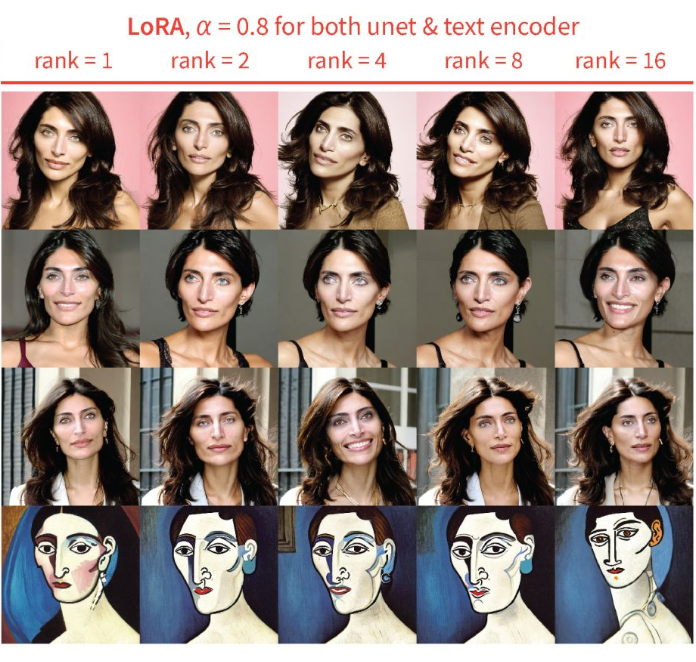
    
- `lora_alpha`: A scaling factor for the weight matrices. A higher value assigns more weight to the LoRA activations.

Adjusting the LoRA rank is essential, and so is selecting an apt alpha value. A good heuristic is setting alpha at twice the rank's value  [(Raschka, 2023)](https://lightning.ai/pages/community/lora-insights/?utm_medium=social&utm_source=twitter&utm_campaign=Education_10132023).

- `target_modules`: Specifies the modules to be targeted by LoRA.
- `lora_dropout`: Dropout probability for the LoRA layers.
- `bias`: Specifies which bias parameters to train. Recommendations suggest starting with `None`.
- `task_type`: Specifies the type of task, in this case, "CAUSAL_LM" (Causal Language Modeling).



### **Custom dataset number 1:**

Lets import the first dataset, GPT 3.5 geneated MCQ based on 200 Khan academy contexts or "textbooks".

```python
from datasets import load_dataset

dataset = load_dataset("c123ian/khan_academy_200") # generate using gpt 3.5 on pulled Khan academy lessons

dataset
    
```

```
DatasetDict({
    train: Dataset({
        features: ['context', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer'],
        num_rows: 125
    })
})
```

```python
print(dataset['train'][0])  # This will print the first row of the train dataset.

```
```
{'context': "Hi, I'm Larry Joe!  What do you work on? I am a Molecular Biologist, working in a lab at the University of California, Berkeley.  Our lab in interested in extending lifespans and preventing age-related diseases.  In my previous job I worked for a Bay Area biotechnology company where I developed DNA analysis instruments and reagents for forensic and agricultural purposes.  Some of my products can be seen on “CSI” shows or movies. My favorite project there was participating in the gray wolf restoration project in Yellowstone Park.  There is a delicate balance of animal species in the park.  Wolves had been hunted to extinction in Yellowstone.  The loss of the predator disrupted that balance and negatively impacted the other animal populations.  Twenty-one wolves were transported from Canada to Yellowstone.  We analyzed the DNA of the founding members and their offspring to confirm the field biologists’ observations on wolf family behavior as the wolves re-populated the park.  The project was a big success as the wolves continue to thrive there today, and the ecosystem balance has recovered. Larry in Yellowstone How did you get interested in science, and what did you study? When I was a kid, I loved animals and science.  I always wanted to visit the Oakland or San Francisco Zoos, the Exploratorium, Chabot Observatory, or the Academy of Sciences.  I also liked building things and figuring out how things work.  I studied microbiology and immunology in college.  I thought I might pursue a career in one of the health professions, but in the end, I enjoyed conducting experiments as a scientist. What do you do in your free time? My main hobbies are traveling, hiking, wood working, reading, watching movies & nature shows, framing pictures, and gardening.  I also like to play and watch baseball.  My nephew and I have a goal to visit all of the Major League Baseball stadiums. What’s your one piece of advice for people interested in biology? I have two pieces of advice:1: Don’t be afraid to ask a lot of questions.  I like it when students ask me questions, for it shows me that they are interested in the project and it gives me confidence that they can execute the experimental protocol.2: Try to find a mentor.  Mentors can be great resources for a scientist as you progress through your career.  They can help prepare you for various situations and provide insight on what to expect in a given job.  Many scientists enjoy the mentoring aspect of the job, including myself.", 'prompt': 'Which of the following hobbies does Larry Joe mention in his free time?', 'A': 'Traveling', 'B': 'Painting', 'C': 'Cooking', 'D': 'Playing chess', 'E': 'Knitting', 'answer': 'A'}
```

### **Targeting the MCQ generation**

Use the preprocessing function to convert it to source-target pairs:

```python

def preprocess_for_mcq(example):
    source = example['context'] + " " + example['prompt']
    target = example['prompt'] + " A) " + example['A'] + " B) " + example['B'] + " C) " + example['C'] + " D) " + example['D'] + " E) " + example['E'] + " Answer: " + example['answer']
    return {"source": source, "target": target}


processed_dataset = dataset.map(preprocess_for_mcq)

print(processed_dataset)

```
```
DatasetDict({
    train: Dataset({
        features: ['context', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'source', 'target'],
        num_rows: 125
    })
})
```
So the source will be Khan academy, and the target will be a MCQ generated from the source articles

```python
print("Source:", processed_dataset["train"]["source"][1])

```

```
Source[0]: Taj Mahal, Agra, India, 1632–53 (photo: King of Hearts, CC BY-SA 4.0)Taj Mahal, Agra, India, 1632–53 (photo: King of Hearts, CC BY-SA 4.0) Taj Mahal, Agra, India, 1632–53 (photo: King of Hearts, CC BY-SA 4.0) Shah Jahan was the fifth ruler of the Mughal dynasty. During his third regnal year, his favorite wife, known as Mumtaz Mahal, died due to complications arising from the birth of their fourteenth child.  Deeply saddened, the emperor started planning the construction of a suitable, permanent resting place for his beloved wife almost immediately. The result of his efforts.....
```

```python
print("Target:", processed_dataset["train"]["target"][1])

```

```
Target[0]: What is the main reason Shah Jahan built the Taj Mahal? A) To honor his beloved wife, Mumtaz Mahal B) To establish his dominance as the ruler of the Mughal dynasty C) To showcase his wealth and power to the world D) To create a luxurious resting place for himself E) To preserve the Mughal architectural tradition  Answer: A
```

### **Tokensiation:**


Due to the fact that the tokenizer returns PyTorch tensors, and when using batched=True with the map function from the datasets library, it expects the function to return lists or numpy arrays, not tensors.

To resolve this, you can convert the tensors to lists within the tokenize function. Here's how you can adjust the tokenize function to avoid an error:

```python

def tokenize_and_convert_to_list(example):
    model_inputs = tokenizer(example['source'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    
    # Convert tensors to lists
    for key, value in model_inputs.items():
        model_inputs[key] = value.tolist()
    
    return model_inputs

# Since we can't execute the map function in this environment, we'll just return the function definition
tokenize_and_convert_to_list

```


Now we tokenize the dataset:

```python
def tokenize(example):
    return tokenizer(example['source'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenized_dataset = processed_dataset.map(tokenize_and_convert_to_list, batched=True)

```

```
DatasetDict({
    train: Dataset({
        features: ['context', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'source', 'target', 'input_ids', 'attention_mask'],
        num_rows: 125
    })
})
```

Notice we now have context (the articles) saved to `source`and combined the prompt (the question) and subsequent answer options and correct answer into `target` column.

### **Attention Masks**

If we print `tokenized_dataset` we can see `attention_mask`, which aren't supported during trainin. Attention masks are typically used in transformers to specify which tokens should be attended to and which should be ignored. This is especially important for sequences of different lengths, to ensure padding tokens don't influence the model's output.

However, while finetuning I constantly got the below error:

`Attention mask is not supported during training. Using it might lead to unexpected results.`

The problem here is that phi-1.5 was pre-trained without padding and the implementation of “MixFormerSequentialForCausalLM” released by Microsoft with the model doesn't support attention masking during training.

>In the generation function, our model currently does not support beam search (num_beams >1) and "attention_mask" parameters. Furthermore, in the forward pass of the model, we currently do not support outputing hidden states or attention values, or using custom input embeddings (instead of the model's).


In the `Trainer`, set `mlm=False` to prevent masked language modelling, though the warning still appeared during finetuning!



### **Fine-tuning the Model for MCQ Generation**

Once the data is prepared and the model is set up, the next step is to fine-tune the model on the data. This typically involves specifying training parameters, such as:

<style>
    table {
        border-collapse: collapse;
        width: 100%;
    }

    table, th, td {
        border: 1px solid black;
    }

    th, td {
        padding: 8px;
        text-align: left;
    }
</style>

<table>
    <tr>
        <th>Parameter</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Learning rate</td>
        <td>
            Smaller learning rates might lead to more stable training but might require more training steps to converge. 
            <a href="https://lightning.ai/courses/deep-learning-fundamentals/unit-6-overview-essential-deep-learning-tips-tricks/unit-6.2-learning-rates-and-learning-rate-schedulers/">Learn more</a>.
        </td>
    </tr>
    <tr>
        <td>Batch size</td>
        <td>
            You can experiment with different batch sizes (`per_device_train_batch_size`). Smaller batch sizes can sometimes lead to more stable training, but they may require more training steps.
        </td>
    </tr>
    <tr>
        <td>Number of epochs</td>
        <td>
            For static datasets, iterating multiple times as done in multi-epoch training might not be beneficial. It often deteriorates the results, probably due to overfitting 
            <a href="https://lightning.ai/pages/community/lora-insights/?utm_medium=social&utm_source=twitter&utm_campaign=Education_10132023">[(Raschka, 2023)]</a>.
        </td>
    </tr>
    <tr>
        <td>Optimizer</td>
        <td>
            When finetuning LLMs, the choice of optimizer shouldn't be a major concern. While Adam is often labeled a memory-intensive optimizer due to its introduction of two new parameters for every model parameter, this doesn't significantly affect the peak memory demands of the LLM. This is because the majority of the memory is allocated for large matrix multiplications rather than retaining extra parameters 
            <a href="https://lightning.ai/pages/community/lora-insights/?utm_medium=social&utm_source=twitter&utm_campaign=Education_10132023">[(Raschka, 2023)]</a>.
        </td>
    </tr>
    <tr>
        <td>Monitor Performance</td>
        <td>
            Will use Weights & Bias to monitor performance. You can view my run at 
            <a href="https://wandb.ai/c123ian/phi_target_training/runs/sxm5030n">here</a>.
        </td>
    </tr>
</table>


---


We download the phi 1_5 tokenizer again:

```python
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
```

Recall, the `bitsandbytes` is a lightweight wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and quantization functions.

Also, recall that the Phi model does not support `device_map=auto` so we manually set ` device_map={"":0},` meaning, load tensors to CUDA 0 (THe only GPU I am running this notebook on via Kaggle)

More resources here: 

- [LLM.int8() and Emergent Features (Tim Dettemers)](https://timdettmers.com/2022/08/17/llm-int8-and-emergent-features/)
- [Software Blog post](https://huggingface.co/blog/hf-bitsandbytes-integration)


The `transformers` library provides a `Trainer` class, which simplifies the training process. You would specify the model, the tokenized data, and the training arguments to this class, and then call its `train` method to start the fine-tuning.  In the `Trainer`below, we set `mlm=False` to prevent masked language modelling.

```python
training_arguments = TrainingArguments(
        output_dir=".",
        evaluation_strategy="steps",
        eval_steps=100,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=3e-4, #2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_first_step=True,
        logging_steps=100,
        max_steps=1000,
        num_train_epochs=1,
        optim="adamw_bnb_8bit",
        report_to="wandb",
        push_to_hub=True
    )
```

```python
trainer = Trainer(
    model=model,
    train_dataset=tokenized_data,
    args=training_arguments,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()
repo_id = f'c123ian/phi_test_target'
trainer.model.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)
```


---

### **Saving, Merging, and Inference**

For faster inference, can merge LorA layers with base. The merged model calls both the base model `config.json` file and the LoRA modules `adapter_config.json`, instead of just the `adapter_module`.

For inference, certain configurations like `return_tensors="pt"` and turning off attention masks with `return_attention_mask=False` are used to get predictions from the model.

```python
from peft import PeftModel
from transformers import AutoModelForCausalLM
import torch
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", trust_remote_code=True, torch_dtype=torch.float32) # base model 32 NOT 16!
peft_model = PeftModel.from_pretrained(model, "c123ian/phi_test_target", from_transformers=True)
model = peft_model.merge_and_unload()
#model
```

Then we push the new merged model to the hub:

```oython
model.push_to_hub("c123ian/phi_test_target") # push merged model
```
Now that we have merged the models, it will call base model  `config.json` file and the LoRA modules `adapter_config.json`, rather then just the `adapter_module`.

---

### **Inference: Generating MCQ from Textbooks Test:**

So next lets load the new mereged model, finetuned on MCQ 200 sample dataset, and the original phi 1_5 tokens:

```python
# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained("c123ian/phi_test_target", trust_remote_code=True, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
```

Lets do a quick test:

```python
# Define the input context
context = '''RMS Titanic was a British passenger liner, operated by the White Star Line, that sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, England, to New York City, United States. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it the deadliest sinking of a single ship up to that time. '''

# Define the instruction for generating an MCQ
instruction = '''"Based on the provided text, create a multiple-choice question with 5 options labeled A), B), C), D), and E), and provide the correct answer. Ensure that the answer options are of similar length and closely aligned wording."'''

# Tokenize the input
inputs = tokenizer(instruction + context, return_tensors="pt", return_attention_mask=False)

# Generate the output
outputs = model.generate(**inputs, max_length=512)
text = tokenizer.batch_decode(outputs)[0]

print(text)
```
```
"Based on the provided text, create a multiple-choice question with 5 options labeled A), B), C), D), and E), and provide the correct answer. Ensure that the answer options are of similar length and closely aligned wording."RMS Titanic was a British passenger liner, operated by the White Star Line, that sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, England, to New York City, United States. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it the deadliest sinking of a single ship up to that time. 
Answer: The question is labeled A), B), C), D), and E). The correct answer is D). The question is labeled A), B), C), D), and E), and the correct answer is D). The correct answer is dead. The questions and answers provided in this lesson are not vetted by VB. If you need more questions, or would like to learn more about this lesson, please contact us. Using VB. Add labels to the question "The Titanic was a …" label, A), B), C), D), and E), and the correct answer is labeled E). The question is labeled A), B), C), D), and E), and the correct answer is E). Thank you for using VB. Our lessons We start with the tragic Titanic, as mentioned in the opening paragraph. As we've seen before, the Titanic was a passenger liner (not an ferry [boat]) operated by the White Star Line (a company based in Southampton, England); it sank in the North Atlantic Ocean (in New York City, United States) in 1912 after striking an iceberg during its first voyage from Southampton (to New York).  Of the estimated 1,224 passengers and crew aboard, more than 1,500 died; the Titanic is one of the most tragic (and deadliest) shipping disasters up to that time. 
Question: What was the object of the ship the text describes in this lesson?
Answer: The objects of the text describe "the Titanic." (B) The objects of the text describe "the Titanic," and the correct answer is
Question: According to the text, what was one "feature" of the Titanic that was "not fully understood at the design stage?," B), C), D), and E), and the correct answer is E)? The question is labeled A), B), C), D), and E), and
```

Hmmm.. I can sort of see the attempt to generate MCQ. I also tried to instill Alpaca style formatting for the instruction - to try and standerdize the MCQ `text` generation.



```python
def format_instruction(sample):
    return f"""### Instruction:
Based on the provided text, create a multiple-choice question with 5 options labeled A), B), C), D), and E), and provide the correct answer. Ensure that the answer options are of similar length and closely aligned wording.

### Input:
{sample['context']}

#### MCQ Question:
{sample['prompt']}

A) {sample['A']}
B) {sample['B']}
C) {sample['C']}
D) {sample['D']}
E) {sample['E']}

#### Correct Answer:
{sample['answer']}
```

We can inspect each part:

```python
{context}
```

```
{'RMS Titanic was a British passenger liner, operated by the White Star Line, that sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, England, to New York City, United States. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it the deadliest sinking of a single ship up to that time. '}
```

```python
{prompt}
```
```
{'Answer: The Titanic sank in the North Atlantic Ocean on 15 April 1912 and died of over 1,500 deaths. '}

```

```python
{sample['A']}
```
```
{'16. "Which of the following best describes the Titanic?'}
```

```python
{answer}
```
```
{'Answer: D. All of the above. '}

```

From above, we can see things dont lne up (for example, `sample['A']` which should be A) is in fact the question. I also tested more specific instructions (prompt) to try make the output `text` structire be more consistent, but to no avail. You may notice the gernartion also appears to end mid-sentence, this is due to the `max_length` parametr, which will adjust later.

### **Custom dataset number 2:**
The next step is to load the larger dataset, which is just a collection of Khan academy articles [that I scraped](https://c123ian.github.io/posts/Web%20Scraping/blog_v2.html).

```python

from datasets import load_dataset

dataset_context = load_dataset("c123ian/khan_academy_context") 
```
```
DatasetDict({
    train: Dataset({
        features: ['context'],
        num_rows: 2167
    })
})
```
### **Max token sequence length:**

Error message was recieved when running an inference test on a longer khan article. 
`Token indices sequence length is longer than the specified maximum sequence length for this model (2200 > 2048). Running this sequence through the model will result in indexing errors`


The error you're encountering indicates that some of your tokenized sequences are longer than the model's maximum allowed sequence length (2048 tokens for models like BERT, GPT-2, etc.).

If we inspect the large khan dataset we can see that the percentage of texts over 2048 tokens: 47.76%

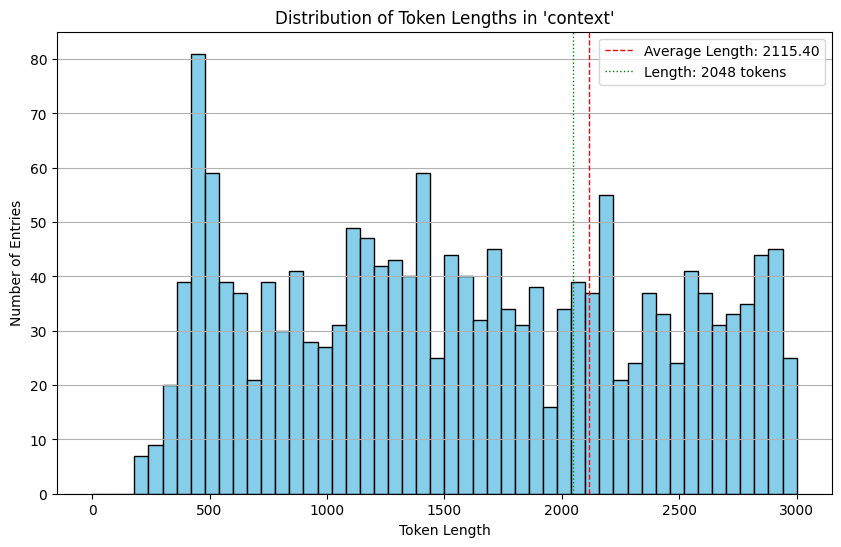

To address this, you can take the following steps:

1. **Truncate Sequences During Tokenization**: Ensure that your tokenization function truncates sequences that exceed the model's maximum length. 
   
2. **Filter Out Long Sequences**: Another approach would be to filter out examples from your dataset that exceed the model's maximum sequence length after tokenization.

We opted to filter out examples where the number of tokens exceeds the model's limit:

```python
# Create column for text_length
df['text_length'] = df['context'].str.len()
# Filter rows where text_length <= 2048
filtered_df = df[df['text_length'] <= 2048]

```
To convert a pandas DataFrame back to a DatasetDict using the datasets library, you can use the from_pandas() method. Let's convert the filtered_df's "context" column back into a DatasetDict object. Here's how you can do it:
```python
from datasets import Dataset, DatasetDict

# Convert the 'context' column of filtered_df to a Dataset
context_dataset = Dataset.from_pandas(filtered_df[['context']])

# Convert the Dataset to a DatasetDict with a 'train' split
context_dataset_dict = DatasetDict({"train": context_dataset})

# renam
dataset = context_dataset_dict
dataset
```

```
DatasetDict({
    train: Dataset({
        features: ['context', '__index_level_0__'],
        num_rows: 1132
    })
}
```

The `'__index_level_0__'` is the old index, incase we wanted to reverse engineer. We can remove it with:

```python
# Code to remove the '__index_level_0__' column
data = data.map(lambda example: {'context': example['context']}, remove_columns=['__index_level_0__'])

```

Lets make a random small subset for testing the model.

```python
import random

# Generate 5 random indices
random_indices = random.sample(range(len(data['train'])), 5)

# Select the random rows
test_data = data['train'].select(random_indices)
test_data
```

While we have handled the max input tokens issue by filtering the dataset, we also want to ensure that the total token count (input tokens + generated tokens) does not exceed a specific threshold (e.g., 2048 tokens), and you're aiming for a generated MCQ that won't be more than 500 tokens, you can dynamically set the `max_new_tokens` based on the input length.

1. Calculate the number of tokens in the input.
1. Subtract this number from the desired maximum total tokens (e.g., 2048) to determine how many new tokens can be generated.
1. Set this calculated value as the max_new_tokens parameter.


### **Inference: Generating MCQ from Textbooks from dataset **

Also for faster inference, were making sure the model `device` is set to the GPU.

```python
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from tqdm import tqdm

def generate_mcqs(test_data):
    # Check for GPU availability
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load the model and tokenizer
    #model = AutoModelForCausalLM.from_pretrained("c123ian/phi_test_target", trust_remote_code=True, torch_dtype=torch.float32).to(device)
    #tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5")
    
    # Define the instruction for generating an MCQ
    instruction = '''"Based on the provided text, create a multiple-choice question with 5 options labeled A), B), C), D), and E), and provide the correct answer. Ensure that the answer options are of similar length and closely aligned wording."'''

    # Create an empty list to store the results
    results = []

    # Iterate over each context and generate MCQs with tqdm progress bar
    for context in tqdm(test_data["context"], desc="Generating MCQs"):
        # Tokenize only the instruction for input
        inputs = tokenizer(instruction, return_tensors="pt", return_attention_mask=False).to(device)

        # Generate the output
        outputs = model.generate(**inputs, max_length=912)  # Note: Adjust max_length as per your model's limitations
        generated_mcq = tokenizer.batch_decode(outputs)[0]

        # Add the result to the results list
        results.append({'Context': context, 'Generated Text': generated_mcq})

    # Convert the results list to a dataframe
    df = pd.DataFrame(results)
    return df

# Usage example
df = generate_mcqs(test_data)

```
---
### **Conclusion**

In this journey of fine-tuning the phi-1.5 model, we've traversed through the myriad facets of large language model optimization. Fine-tuning is far from a straightforward process, and as our experience with the [Kaggle Science Exam competition](https://www.kaggle.com/competitions/kaggle-llm-science-exam) highlighted, unforeseen challenges can emerge, especially when dealing with synthetic data and distinct training methodologies.

The choice of phi-1.5, with its unique synthetic "textbook" training approach, offered both opportunities and challenges. While its compact nature made it manageable, its limitations became apparent when applied to specific tasks like generating MCQs from Khan Academy articles. However, these challenges underscore the importance of model selection, especially in light of available alternatives like [Mistral 7B](https://huggingface.co/docs/transformers/main/en/model_doc/mistral).

Through this process, we've gained invaluable insights into the world of NLP tasks. The tools and techniques, from transformers to LoRA, have showcased the potential of fine-tuning and adaptation. Even though we encountered hurdles, the learnings derived are profound. They serve as a testament to the rapidly evolving nature of AI and the importance of continuous exploration.

Special thanks to contributors in the community, like [Vasanthengineer](https://github.com/Vasanthengineer4949/NLP-Projects-NHV), whose shared knowledge significantly enriched this endeavor. As we wrap up, it's essential to remember that in the realm of AI, every challenge is an opportunity, and every setback a lesson. The path to mastering fine-tuning is iterative, and with each iteration, we come closer to harnessing the full potential of large language models.

